# Preamble

Title: *FBI Crime Data (Murders, by state and weapon) (2019)*

Author: *Dakota M. Miller*

Email: *dmil166 @ msudenver.edu*

Last Update: *2021-10-02*


# Introduction

This report presents the preliminary results of an analysis of crime data in the United States in 2019. Data for this report was obtained from information published annually by the Federal Bureau of Investigation. An additional similarity analysis was generated comparing total murders by state to state population to test a theory that these two datasets are positively correlated.

# Dataset

The dataset for this report was built from information published at [FBI Crime Data](https://ucr.fbi.gov/crime-in-the-u.s/2019/crime-in-the-u.s.-2019/topic-pages/tables/table-20) and [Census.gov](https://www.census.gov/newsroom/press-kits/2019/national-state-estimates.html). Web-scraping techniques were employed to compile murders by state and weapons for annual reported crimes in the year 2019. Murder data declarations include:

1. Total number of murders for which supplemental homicide data were received.
2. Pushed is included in hands, fists, feet, etc.
3. Limited data for 2019 were available for Alabama.
4. Data submitted through the Bureau of Indian Affairs.
5. Limited supplemental homicide data were received.
6. Puerto Rico is included in both data sets (as a major US Territory)

The script below automatically extracts annual reported murders in the year 2019. The information is sourced from an HTML table and stored in a Python lists of lists with the following structure:

```
[
State,Handguns,Rifles,Shotguns,"Firearms (type unknown)","Knives or cutting instruments","Other weapons","Hands|fists|feet, etc."
Alabama,3,0,0,0,0,1,0
Alaska,17,1,6,20,8,5,12
...
Wyoming,7,0,0,2,3,0,1
]
```

The population data (obtained through CSV interaction) for the scatter plot analysis has the following structure (note: only 2019 will be used):
```
[
Category,Subcategory,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Nation,United States,"309,321,666","311,556,874","313,830,990","315,993,715","318,301,008","320,635,163","322,941,311","324,985,539","326,687,501","328,239,523"
Region,Northeast,"55,380,134","55,604,223","55,775,216","55,901,806","56,006,011","56,034,684","56,042,330","56,059,240","56,046,620","55,982,803"
Region,Midwest,"66,974,416","67,157,800","67,336,743","67,560,379","67,745,167","67,860,583","67,987,540","68,126,781","68,236,628","68,329,004"
Region,South,"114,866,680","116,006,522","117,241,208","118,364,400","119,624,037","120,997,341","122,351,760","123,542,189","124,569,433","125,580,448"
Region,West,"72,100,436","72,788,329","73,477,823","74,167,130","74,925,793","75,742,555","76,559,681","77,257,329","77,834,820","78,347,268"
State,Alabama,"4,785,437","4,799,069","4,815,588","4,830,081","4,841,799","4,852,347","4,863,525","4,874,486","4,887,681","4,903,185"
State,Alaska,"713
...
State,Wyoming,"564,487","567,299","576,305","582,122","582,531","585,613","584,215","578,931","577,601","578,759"
]
```

CS390Z - Introduction to Data Mining - Fall 2021

Student: Dakota M. Miller

Description: Configuration & Data Collection

### Library Imports

In [1]:
from bs4 import BeautifulSoup
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from sklearn.metrics import r2_score
import statistics as stats
import sys
import wordninja

### Definitions/Parameters

In [2]:
os.chdir(globals()['_dh'][0])
os.chdir('../')
DATA_FOLDER = os.path.join(os.getcwd(), 'data')
CENSUS_FILE_NAME = 'census_data.csv'
CENSUS_FILE_PATH = os.path.join(DATA_FOLDER, CENSUS_FILE_NAME)
BASE_YEAR = 2019
BASE_URL = 'https://ucr.fbi.gov/crime-in-the-u.s/2019/crime-in-the-u.s.-2019/topic-pages/tables/table-20'
HEADERS = {"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) "
                         "Chrome/81.0.4044.141 Safari/537.36"}

### Resources

In [3]:
#   https://www.pythonpool.com/python-check-if-string-is-integer/
#   http://python-notes.curiousefficiency.org/en/latest/python3/text_file_processing.html#what-changed-in-python-3
#   https://www.kite.com/python/answers/how-to-remove-a-comma-from-a-string-in-python
#   https://www.pluralsight.com/guides/extracting-data-html-beautifulsoup
#   https://www.crummy.com/software/BeautifulSoup/bs4/doc/#attributes
#   https://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words
#   https://www.geeksforgeeks.org/python-string-join-method/
#   https://stackoverflow.com/questions/5193811/how-can-i-check-for-a-new-line-in-string-in-python-3-x
#   https://msudenver.instructure.com/courses/47959/pages/cs-390z-matplotlib
#   https://stackoverflow.com/questions/6473679/transpose-list-of-lists
#   https://stackabuse.com/rotate-axis-labels-in-matplotlib/
#   https://www.educative.io/edpresso/how-to-emulate-a-do-while-loop-in-python
#   https://stackoverflow.com/questions/26785354/normalizing-a-list-of-numbers-in-python
#   https://www.geeksforgeeks.org/creating-pandas-dataframe-using-list-of-lists/

### Data Collection - Crime Data

In [4]:
# Make a GET request to fetch the raw HTML content
html_content = requests.get(BASE_URL, verify=False).text

# Parse the html content
soup = BeautifulSoup(html_content, "html.parser")
table_data = soup.find('table').text.strip()
table_header_text, table_body_text = table_data.split('\n\n\n\n\n\n\n')

crime_col_headers = list(table_header_text.replace('\n\n\n', '\n\n').split('\n\n'))
for compound_headers_index in range(len(crime_col_headers)):
    word_sep = ' '
    crime_col_headers[compound_headers_index] = word_sep.join(
        wordninja.split(crime_col_headers[compound_headers_index]))
for header_index in range(len(crime_col_headers)):
    if crime_col_headers[header_index][-1].isdigit():
        crime_col_headers[header_index] = crime_col_headers[header_index][0:-1].title()
    else:
        crime_col_headers[header_index] = crime_col_headers[header_index].title()

all_crime_rows = list(table_body_text.replace('\n\n\n', '\n\n').split('\n\n'))

crime_row_headers = []
new_state_row = []
crime_data = []
crime_state_total = []
crime_state_firearm_total = []
for element in all_crime_rows:
    if element.strip().replace(' ', '').isalnum() and not element.replace(',', '').isdigit():
        if element[-1].isdigit():
            new_state_row = [element[0:-1].strip()]
        else:
            new_state_row = [element.strip()]
    elif element.replace(',', '').isdigit():
        new_state_row.append(int(element.replace(',', '')))
    else:
        print("I don't know that data type! Abort mission!")
        sys.exit(0)

    if len(new_state_row) == 10:
        crime_row_headers.append(new_state_row[0])
        crime_state_total.append(new_state_row[1])
        crime_state_firearm_total.append(new_state_row[2])
        crime_data.append(new_state_row[3:])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ucr.fbi.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


### Data Collection - Census Data

In [5]:
census_data = []
census_col_headers = []
census_regions = []
census_subcategories = []
census_states = []
census_data_BASE_YEAR = []
with open(CENSUS_FILE_PATH, 'rt', encoding='utf-8') as csv_file:
    reader = csv.reader(csv_file)
    row_count = 0
    for row in reader:
        index = 0
        census_state_data = []
        row_count += 1
        if row_count == 1:
            for item in row:
                census_col_headers.append(str(item))
        else:
            for item in row:
                if index == 0:
                    census_regions.append(item)
                elif index == 1:
                    census_subcategories.append(item)
                else:
                    census_state_data.append(int(item.replace(',', '')))
                index += 1
            if census_regions[-1] == 'State':
                census_states.append(census_subcategories[-1])
                census_data_BASE_YEAR.append(census_state_data[-1])
            census_data.append(census_state_data)


# Summary Statistics


CS390Z - Introduction to Data Mining - Fall 2021

Student: Dakota M. Miller

Description: Summary Statistics

## Murder Data

In [6]:
crimes_total_array = np.array(crime_state_total)
print('*** Summary Statistics of ' + str(BASE_YEAR) + ' Crimes Data ***')
crime_records = '{:,.0f}'.format(len(crime_state_total))
print(f'#records: {crime_records}')
crimes_minimum = '{:,.0f}'.format(np.min(crimes_total_array))
crimes_maximum = '{:,.0f}'.format(np.max(crimes_total_array))
print(f'Count of Crimes Range: [{crimes_minimum} , {crimes_maximum}]')
crimes_mean = '{:,.2f}'.format(np.mean(crimes_total_array))
print(f'Count of Crimes Mean: {crimes_mean}')
crimes_median = '{:,.0f}'.format(np.median(crimes_total_array))
print(f'Count of Crimes Median: {crimes_median}')
crimes_std = '{:,.2f}'.format(np.std(crimes_total_array))
print(f'Count of Crimes StD: {crimes_std}')

*** Summary Statistics of 2019 Crimes Data ***
#records: 51
Count of Crimes Range: [1 , 1,679]
Count of Crimes Mean: 273.08
Count of Crimes Median: 166
Count of Crimes StD: 325.81


## Census Data

In [7]:
census_totals_BASE_YEAR_array = np.array(census_data_BASE_YEAR)
print('\n*** Summary Statistics of ' + str(BASE_YEAR) + ' Census Data ***')
census_records = '{:,.0f}'.format(len(census_states))
print(f'#records: {census_records}')
census_minimum = '{:,.0f}'.format(np.min(census_totals_BASE_YEAR_array))
census_maximum = '{:,.0f}'.format(np.max(census_totals_BASE_YEAR_array))
print(f'{str(BASE_YEAR)} Census Range: [{census_minimum} , {census_maximum}]')
census_mean = '{:,.2f}'.format(np.mean(census_totals_BASE_YEAR_array))
print(f'{str(BASE_YEAR)} Census Mean: {census_mean}')
census_median = '{:,.0f}'.format(np.median(census_totals_BASE_YEAR_array))
print(f'{str(BASE_YEAR)} Census Median: {census_median}')
census_std = '{:,.2f}'.format(np.std(census_totals_BASE_YEAR_array))
print(f'{str(BASE_YEAR)} Census StD: {census_std}\n\n')


*** Summary Statistics of 2019 Census Data ***
#records: 51
2019 Census Range: [578,759 , 39,512,223]
2019 Census Mean: 6,436,069.08
2019 Census Median: 4,467,673
2019 Census StD: 7,288,139.88




# Visualizations

CS390Z - Introduction to Data Mining - Fall 2021

Student: Dakota M. Miller

Description: Data Visualizations

## Histogram

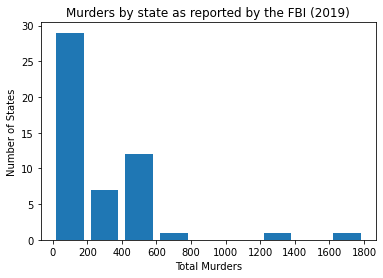

In [8]:
BIN_SIZE = 200
min_x_val_histogram = min(crime_state_total) // BIN_SIZE
max_x_value_histogram = ((max(crime_state_total) // BIN_SIZE) + 2) * BIN_SIZE
bin_list = list(range(min_x_val_histogram, max_x_value_histogram, BIN_SIZE))
bin_label_list = []
for x in range(len(bin_list) - 1):
    bin_label_list.append(str(bin_list[x] / 1000) + 'K')

fig, ax = plt.subplots()
counts, bins, _ = plt.hist(
    crime_state_total,
    range=(min_x_val_histogram, max_x_value_histogram),
    bins=bin_list,
    rwidth=0.8

)
plt.xticks(np.arange(min_x_val_histogram, max_x_value_histogram, BIN_SIZE))

plt.xlabel('Total Murders')
plt.ylabel('Number of States')
plt.title('Murders by state as reported by the FBI (' + str(BASE_YEAR) + ')')

plt.show()

## Box Plot

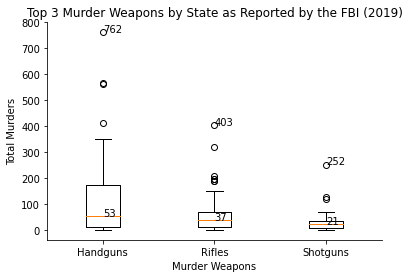

In [9]:
crime_data_transpose = list(map(list, zip(*crime_data)))

# Below code will remove top & bottom 10% of outliers
# for weapon_rows in crime_data_transpose:
#     weapon_rows_length = len(weapon_rows)
#     outliers = weapon_rows_length // 10
#     for iterations in range(outliers):
#         weapon_rows.remove(min(weapon_rows))
#         weapon_rows.remove(max(weapon_rows))

BOX_PLOTS_TO_SHOW = 3
while len(crime_data_transpose) != BOX_PLOTS_TO_SHOW:
    for decrease_iter in range(10, 1, -1):
        threshold = max(max(crime_data_transpose)) // decrease_iter
        for sanity_check in crime_data_transpose:
            if max(sanity_check) < threshold:
                crime_data_transpose.remove(sanity_check)
        if len(crime_data_transpose) == BOX_PLOTS_TO_SHOW:
            break

branches = crime_data_transpose
medians = [stats.median(branch) for branch in branches]
plt.boxplot(
    branches
)
branch_labels = []
i = 0
for branch in branches:
    max_value = max(branch)
    plt.annotate(str(max_value), xy=(i + 1, max_value))
    plt.annotate(str(medians[i]), xy=(i + 1, medians[i]))
    branch_labels.append(crime_col_headers[i + 3])
    i += 1
axes = plt.gca()
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.set_xticklabels(branch_labels)
plt.xlabel('Murder Weapons')
plt.ylabel('Total Murders')
plt.title('Top 3 Murder Weapons by State as Reported by the FBI (' + str(BASE_YEAR) + ')')
plt.show()

## Scatter Plot

Coefficient of determination: 0.63


/var/folders/9x/v176y6kx7js27mvdnptl7hqc0000gn/T/ipykernel_24339/1787125307.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(scatter_x_ticks)


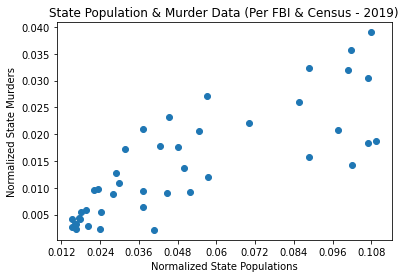

In [10]:
census_totals_norm = [float(i) / sum(census_data_BASE_YEAR) for i in census_data_BASE_YEAR]
crime_totals_norm = [float(i) / sum(crime_state_total) for i in crime_state_total]
total_crime_and_census = [crime_totals_norm, census_totals_norm]

SCATTER_NUM_OF_X_TICKS = 10
max_x_value_x_100 = int(max(total_crime_and_census[0]) * 1000)
scatter_x_ticks = [x for x in range(0, max_x_value_x_100, int(max_x_value_x_100 / SCATTER_NUM_OF_X_TICKS))]
for y in range(len(scatter_x_ticks)):
    scatter_x_ticks[y] = float(scatter_x_ticks[y]) / 1000.0

PERCENT_DATA_POINTS_SCRUBBED = 2
num_scrub_points = math.ceil(len(crime_row_headers) * (PERCENT_DATA_POINTS_SCRUBBED / 100))

for k in range(num_scrub_points):
    max_crime_data_point_index = crime_totals_norm.index(max(crime_totals_norm))
    crime_totals_norm.pop(max_crime_data_point_index)
    census_totals_norm.pop(max_crime_data_point_index)

    max_census_data_point_index = census_totals_norm.index(max(census_totals_norm))
    crime_totals_norm.pop(max_census_data_point_index)
    census_totals_norm.pop(max_census_data_point_index)

    min_crime_data_point_index = crime_totals_norm.index(min(crime_totals_norm))
    crime_totals_norm.pop(min_crime_data_point_index)
    census_totals_norm.pop(min_crime_data_point_index)

    min_census_data_point_index = census_totals_norm.index(min(census_totals_norm))
    crime_totals_norm.pop(min_census_data_point_index)
    census_totals_norm.pop(min_census_data_point_index)

axes = plt.gca()
plt.scatter(total_crime_and_census[0], total_crime_and_census[1])
axes.set_xticklabels(scatter_x_ticks)
plt.xlabel('Normalized State Populations')
plt.ylabel('Normalized State Murders')
plt.title('State Population & Murder Data (Per FBI & Census - ' + str(BASE_YEAR) + ')')
print('Coefficient of determination: %.2f'
      % r2_score(total_crime_and_census[0], total_crime_and_census[1]))
plt.show()